<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/EIP4/session5/010_PersonAttributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a model to classify a Person's attributes

We will build a model that classifies the attributes of a person seen in a photo. As shown in the image below, in addition to the person's attributes , we also try to categorize the image quality .

![classify](https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/classify.png) 


Load project data files from Google drive and import necessary libraries / modules

In [1]:
import tensorflow as tf
#tf.enable_eager_execution()

In [2]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
project_folder="/content/gdrive/My Drive/EIP4/session5"

!rm -R ./resized
!rm hvc_annotations.csv
!unzip -q "/content/gdrive/My Drive/EIP4/session5/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
rm: cannot remove './resized': No such file or directory
rm: cannot remove 'hvc_annotations.csv': No such file or directory
gdrive/  hvc_annotations.csv  resized/  sample_data/


## Crop images to remove black padding 
#### The dataset contained images are of size 224x224 and padded with black pixels . We will remove the black pixels and use the resulting images for our training . Visual inspection of the images shows that many images are 120 pixels or less in actual width and rest is black padding. So take this route of cropping out the black pixels . We could then resize the actual image to various proportions using a datagenerator 
The code used for cropping images is at https://github.com/ravindrabharathi/Project1/blob/master/EIP4/session5/Crop_images_PersonAttributes.ipynb

In [3]:
#%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input,Conv2D,GlobalAveragePooling2D,BatchNormalization,MaxPooling2D,Activation,Lambda,GlobalMaxPooling2D,Add,Concatenate,LeakyReLU,ReLU
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


prevent tensorflow to allocate all the avaliable GPU Memory and allocate as needed

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend

from keras import backend as k
# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

### Remove the original resized folder and replace it with the cropped images resized to 224x112 

In [0]:
!rm -Rf './resized'

Extract cropped images that don't have the black padding 

In [0]:
!tar -xf '/content/gdrive/My Drive/EIP4/session5/cropped.tar' 

function to resize images 

In [0]:
def resize_img(img,dim):
  return cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)

Resize to 112 width and 224 height

In [8]:
import os
image_list2=os.listdir('./cropped/')
!rm -Rf './resized'
!mkdir './resized'
print('starting to resize to 112x224 ...')
for i in range(len(image_list2)):
  image=cv2.imread('./cropped/'+image_list2[i])
  image1=resize_img(image,(112,224))
  #cv2_imshow(image1)
  cv2.imwrite('./resized/'+image_list2[i],image1)
  if (i%1000==0):
    print('processed ',i,'images')

starting to resize to 112x224 ...
processed  0 images
processed  1000 images
processed  2000 images
processed  3000 images
processed  4000 images
processed  5000 images
processed  6000 images
processed  7000 images
processed  8000 images
processed  9000 images
processed  10000 images
processed  11000 images
processed  12000 images
processed  13000 images


check that all images have been resized

In [9]:
print(len(os.listdir('./cropped/')),len(os.listdir('./resized/')))

13573 13573


Function to compute mean and standard deviation of dataset.

In [10]:
'''
image_data=[]
for i in range(len(image_list2)):
  img=cv2.imread('./resized/'+image_list2[i])
  
  image_data.append(img)
image_data=np.array(image_data) 
print(image_data.shape)
images_mean=np.mean(image_data,axis=(0,1,2))
images_std=np.std(image_data,axis=(0,1,2))
print(images_mean,images_std)
'''

"\nimage_data=[]\nfor i in range(len(image_list2)):\n  img=cv2.imread('./resized/'+image_list2[i])\n  \n  image_data.append(img)\nimage_data=np.array(image_data) \nprint(image_data.shape)\nimages_mean=np.mean(image_data,axis=(0,1,2))\nimages_std=np.std(image_data,axis=(0,1,2))\nprint(images_mean,images_std)\n"

### We will use this mean and std in normalizing images . 

In [10]:
images_mean=np.array([ 95.55573314,  96.53671704, 107.34702047])/255.0
images_std= np.array([64.81507208, 65.94565732, 67.6457798 ])/255.0
print(images_mean,images_std)

[0.37472837 0.37857536 0.42096871] [0.25417675 0.25861042 0.26527757]


### Inspect images by plotting some of them . 


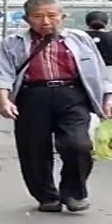

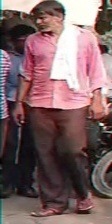

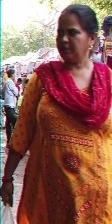

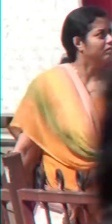

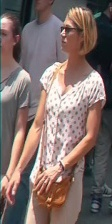

In [12]:
for i in range(5):
  img=cv2.imread('./resized/'+image_list2[i])
  cv2_imshow(img)
  print('\n\n')


In [0]:
def crop_top(img):
  shp=img.shape
  #print('shape',shp)
  h1=img.shape[1]//2
  
  return img[:,0:h1,:,:]

In [0]:
def crop_botm(img):
  shp=img.shape
  #print('shape',shp)
  h1=img.shape[1]//2
  
  return img[:,h1:,:,:]

### We will also use the top part of image for Age training and bottom part separately for Footwear training . Print out some images to check if the functions work as intented 

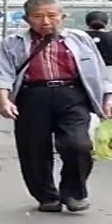

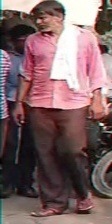

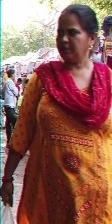

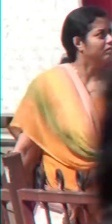

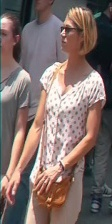




............


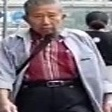

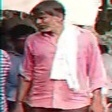

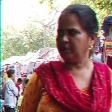

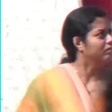

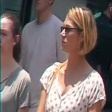

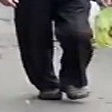

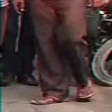

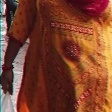

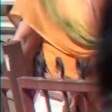

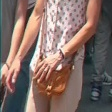

In [15]:
batch1=[]
for i in range(5):
  img=cv2.imread('./resized/'+image_list2[i])
  cv2_imshow(img)
  print("\n\n")
  batch1.append(img)
batch1=np.array(batch1)  
print('............')     
#print(batch1.shape)

batch2=crop_top(batch1)
#print(batch2.shape)

for img in batch2:
  cv2_imshow(img)
  print("\n\n")

batch2=crop_botm(batch1)
#print(batch2.shape)

for img in batch2:
  cv2_imshow(img)
  print("\n\n")



### Now that we have done part of the preparation for images , let us focus on the labels 

Load the csv file containing annotations 

In [11]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 9 columns):
gender          13573 non-null object
imagequality    13573 non-null object
age             13573 non-null object
weight          13573 non-null object
carryingbag     13573 non-null object
footwear        13573 non-null object
emotion         13573 non-null object
bodypose        13573 non-null object
image_path      13573 non-null object
dtypes: object(9)
memory usage: 954.5+ KB


### Plot the distribution of various categories in the dataset . As we can see there is a high imbalance in data for the various person attributes



      --------    gender      --------


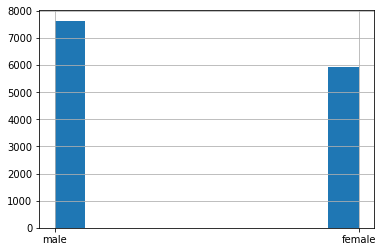



      --------    imagequality      --------


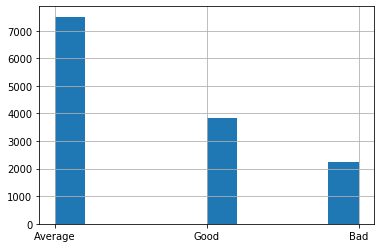



      --------    age      --------


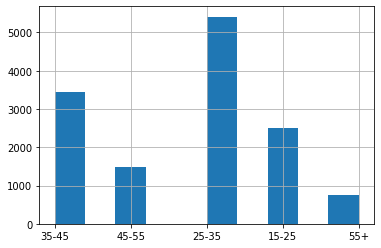



      --------    weight      --------


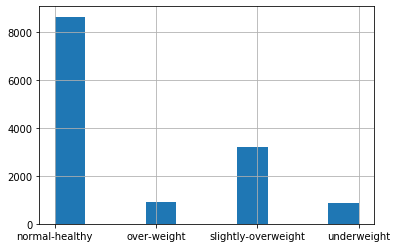



      --------    carryingbag      --------


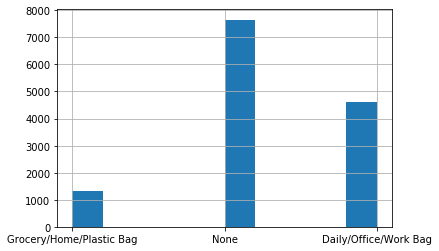



      --------    footwear      --------


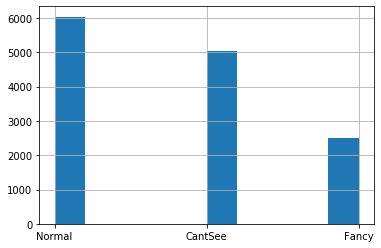



      --------    emotion      --------


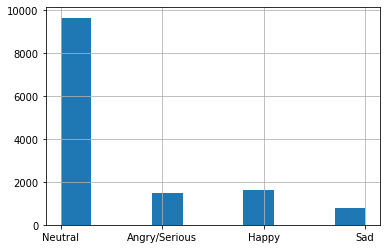



      --------    bodypose      --------


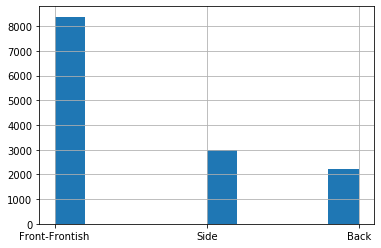

In [12]:
col_list=df.columns.to_list()
for col in col_list[:8]:
  print("\n\n      --------   ",col,"     --------")
  df[col].hist()
  plt.show()

### Convert the various column labels to categories ranging from 0 to n-1 where n is the number of types in a specific attribute/column

### We are doing this categorization instead of one hot encoding the labels and while training, we will use sparse_categorical_crossentropy instead of categorical_crossentropy

In [0]:
def age_cat_fn(age):
  
  age=str(age)
  if (age=="15-25"):
    return 0
  elif(age=="25-35"):
    return 1
  elif (age=="35-45"):
    return 2
  elif (age=="45-55"):
    return 3
  elif (age=="55+"):
    return 4

def gender_cat_fn(gender):
  if (gender=="male"):
    return 0
  else:
    return 1    

def imagequality_cat_fn(quality):
  if str(quality)=='Average':
    return 0
  elif str(quality)=='Good' :
    return 1 
  elif str(quality)=='Bad' :
    return 2   

def weight_cat_fn(weight):
  if str(weight)=='normal-healthy':
    return 0
  elif str(weight)=='slightly-overweight' :
    return 1
  elif str(weight)=='over-weight' :
    return 2   
  elif str(weight)=='underweight' :
    return 3

def bag_cat_fn(bag):
  if str(bag)=='None':
    return 0
  elif str(bag)=='Daily/Office/Work Bag' :
    return 1
  elif str(bag)=='Grocery/Home/Plastic Bag' :
    return 2   

def footwear_cat_fn(footwear):
  if str(footwear)=='Normal':
    return 0
  elif str(footwear)=='CantSee' :
    return 1
  elif str(footwear)=='Fancy' :
    return 2    

def emotion_cat_fn(emotion):
  if str(emotion)=='Neutral':
    return 0
  elif str(emotion)=='Happy' :
    return 1
  elif str(emotion)=='Angry/Serious' :
    return 2  
  elif str(emotion)=='Sad' :
    return 3  

def pose_cat_fn(pose):
  if str(pose)=='Front-Frontish':
    return 0
  elif str(pose)=='Side' :
    return 1
  elif str(pose)=='Back' :
    return 2              

In [0]:
df['age']=df['age'].map(age_cat_fn)

df['gender']=df['gender'].map(gender_cat_fn)

df['imagequality']=df.imagequality.map(imagequality_cat_fn)

df['weight']=df['weight'].map(weight_cat_fn)

df['carryingbag']=df['carryingbag'].map(bag_cat_fn)

df['footwear']=df['footwear'].map(footwear_cat_fn)

df['emotion']=df['emotion'].map(emotion_cat_fn)

df['bodypose']=df['bodypose'].map(pose_cat_fn)



Transformed dataframe after applying 0-n integer categorization of labels 

In [68]:
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,0,0,2,0,2,0,0,0,resized/1.jpg
1,1,0,2,2,0,0,2,0,resized/2.jpg
2,0,1,3,0,2,1,0,0,resized/3.jpg
3,0,1,3,0,1,0,0,0,resized/4.jpg
4,1,1,2,1,0,1,0,0,resized/5.jpg


### Functions for augmentation of images 

Random pad crop 

In [0]:
def pad_img(img):
  pad_size1=img.shape[0]//8
  pad_size2=img.shape[1]//8
  img=np.pad(img, [ (pad_size1, pad_size1), (pad_size2, pad_size2), (0, 0)], mode='reflect')  
  return img 


def random_pad_crop_img(img):
  crop_size1=img.shape[0]
  crop_size2=img.shape[1]
  
  img=pad_img(img)
  pad1=img.shape[0]-crop_size1
  pad2=img.shape[1]-crop_size2
  #print(crop_size1,crop_size2,pad1,pad2)
  x1=np.random.randint(pad1)
  x2=x1+crop_size1
  y1=np.random.randint(pad2)
  y2=y1+crop_size2
  img=img[x1:x2,y1:y2,:]
  return img

Test random_pad_crop function by plotting one sample (original on top and augmented image below)

Original



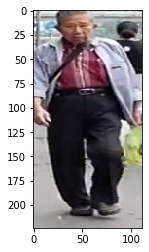



augmented-random_pad_crop



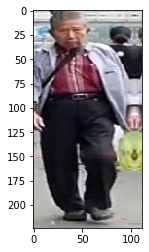

In [31]:

for i in range(1):
  img=plt.imread('./resized/'+image_list2[i])
  print('Original\n')
  plt.imshow(img)
  plt.title='original'
  plt.show()
  img1=random_pad_crop_img(img)
  print('\n\naugmented-random_pad_crop\n')
  plt.imshow(img1)
  
  plt.show()
  print("\n\n")

Cutout Function - Single cutout and a variantion, cutout2, that cuts out two patches - one in the top half and another in bottom half .

Here we set the patch pixel values to 0 since we will also be normalizing the images to a zero mean 

In [0]:
def cutout(img,prob=100):
  if np.random.randint(0,100)<prob:
    s1=img.shape[0]
    s2=img.shape[1]
    x1=np.random.randint(s1)
    x2=x1+np.random.randint(s2//4,s1//2)
    
    x3=np.random.randint(s2)
    x4=x3+np.random.randint(s2//4,s1//2)
    im_mean=np.mean(img,axis=(0,1))
    if x2>s1-1:
      x2=s1-1
    if x4>s2-1:
      x4=s2-1  
    img[x1:x2,x3:x4,:]=0#images_mean

  return img

In [0]:
def cutout2(img,prob=100):
  if np.random.randint(0,100)<prob:
    s1=img.shape[0]
    s2=img.shape[1]
    #print(s1,s2)
    
    x2=s1//4
    x1=np.random.randint(s1//2)-x2
    x3=np.random.randint(s1//2,s1)
    x4=x3+s1//4 #np.random.randint(s2//4,s1//4)

    x5=np.random.randint(s2)
    x6=x5+s1//4 #np.random.randint(s2//4,s1//4)

    x7=np.random.randint(s2)
    x8=x7+s1//4 #np.random.randint(s2//4,s1//4)

    #im_mean=np.mean(img,axis=(0,1))
    if x2>s1-1:
      x2=s1-1
    if x1<0:
      x1=0  
    if x4>s1-1:
      x4=s1-1  
    if x6>s2-1:
      x6=s2-1
    if x8>s2-1:
      x8=s2-1 
    #print(x1,x2,x3,x4,x5,x6,x7,x8) 
    img[x1:x2,x5:x6,:]=0#images_mean
    img[x3:x4,x7:x8,:] =0# images_mean

  return img

Test Cutout function by plotting samples (original on top and augmented image below)

original


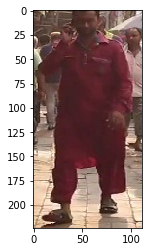



Augmented



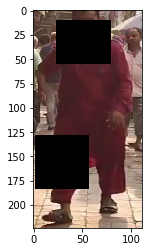

In [34]:
for i in range(70,71):
  img=plt.imread('./resized/'+image_list2[i])
  print('original')
  plt.imshow(img)
  plt.show()
  img1=cutout2(img.copy())
  print("\n\nAugmented\n")
  plt.imshow(img1)
  plt.show()
  print("\n\n")

original


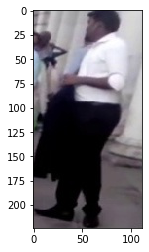



augmented



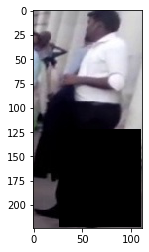

In [35]:
for i in range(50,51):
  img=plt.imread('./resized/'+image_list2[i])
  print('original')
  plt.imshow(img)
  plt.show()
  img1=cutout(img.copy())
  print("\n\naugmented\n")
  plt.imshow(img1)
  plt.show()
  print("\n\n")

Function for horizontal flip

In [0]:
def h_flip(img,prob=100):
  if np.random.randint(0,100)<prob:
    img=np.fliplr(img)
  return img

Test h_flip

original



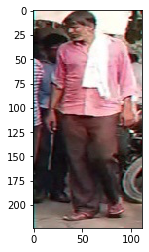



augmented



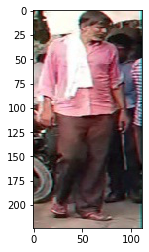

In [37]:
for i in range(1,2):
  img=plt.imread('./resized/'+image_list2[i])
  print('original\n')
  plt.imshow(img)
  plt.show()
  img1=h_flip(img)
  print("\n\naugmented\n")
  plt.imshow(img1)
  plt.show()
  print("\n\n")

Fubnction to standardize/scale pixels valiues in the range 0 to 1

In [0]:
def standardize(img):
  return img.astype('float32')*1.0/255.0

original



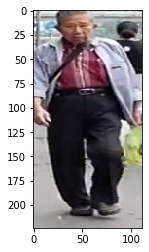



scaled pixel values to 0-1 
 


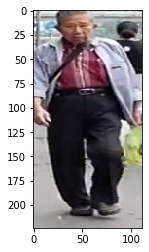

In [40]:
for i in range(1):
  img=plt.imread('./resized/'+image_list2[i])
  print('original\n')
  plt.imshow(img)
  plt.show()
  img1=standardize(img)
  print("\n\nscaled pixel values to 0-1 \n ")
  plt.imshow(img1)
  plt.show()
  print("\n\n")

Function to Normalize pixel value distribution to be 0 centered . This will put the values in the range -1 to 1 distributed around a mean of 0

In [0]:
def normalize(img):
  return (img.astype('float32')-images_mean)/images_std

### Augmenation function combinations to be used in training

In [0]:
def norm_mean(img):
  img=standardize(img)
  img=normalize(img)
  return img

def img_aug1(img):
  img= norm_mean(img)
  img=random_pad_crop_img(img)
  img=cutout(img)
  img=h_flip(img,prob=50)
  
  return img


def img_aug2(img):
  return h_flip(img)  

def img_aug3(img):
  img= norm_mean(img)
  img=random_pad_crop_img(img)
  img=cutout2(img)
  img=h_flip(img,prob=50)
  
  return img      

## Train and Test data 
We will split the data into 85% tra8ning and 15% validation. We have set the randomstate value so that the results are the same every time we run thios function . This will avoid data leaks from validation set to train set .

In [22]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.15,shuffle=True,random_state=2019)
train_df.shape, val_df.shape

((11537, 9), (2036, 9))

In [44]:
train_df.head() 

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
5617,1,2,0,0,0,2,0,0,resized/5618.jpg
8015,1,1,0,3,0,0,3,1,resized/8016.jpg
4727,1,0,1,3,1,2,0,2,resized/4728.jpg
6364,1,0,3,2,0,1,0,0,resized/6365.jpg
2036,0,0,1,0,0,1,0,0,resized/2037.jpg


In [45]:
val_df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
6901,0,1,2,1,1,2,1,0,resized/6902.jpg
3997,0,0,4,0,0,0,2,1,resized/3998.jpg
11983,0,0,2,0,0,0,0,1,resized/11985.jpg
8397,0,0,2,2,2,1,0,2,resized/8398.jpg
5325,1,0,1,0,1,1,0,2,resized/5326.jpg


## head values printed from previous run . They are the same as the current session. This confirms that there is no mixing of validation on train data across multiple runs . We could also have saved the train and val df as csv and loaded them from google drive 

In [46]:
train_df.head() 

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
5617,1,2,0,0,0,2,0,0,resized/5618.jpg
8015,1,1,0,3,0,0,3,1,resized/8016.jpg
4727,1,0,1,3,1,2,0,2,resized/4728.jpg
6364,1,0,3,2,0,1,0,0,resized/6365.jpg
2036,0,0,1,0,0,1,0,0,resized/2037.jpg


In [47]:
val_df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
6901,0,1,2,1,1,2,1,0,resized/6902.jpg
3997,0,0,4,0,0,0,2,1,resized/3998.jpg
11983,0,0,2,0,0,0,0,1,resized/11985.jpg
8397,0,0,2,2,2,1,0,2,resized/8398.jpg
5325,1,0,1,0,1,1,0,2,resized/5326.jpg


### Data distribution of train and validation sets . This shows that the imbalance exists in both train and test sets 



    ----  training samples distribution  ------




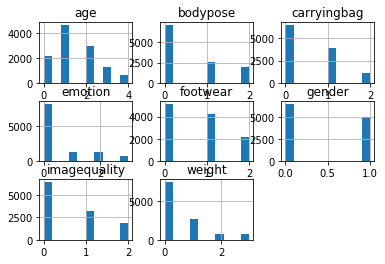



    ----  validation samples distribution  ------




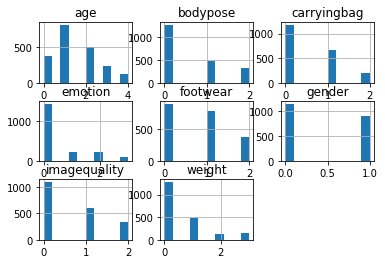

In [23]:

print('\n\n    ----  training samples distribution  ------\n\n')
train_df[col_list].hist()

plt.show()

print('\n\n    ----  validation samples distribution  ------\n\n')
val_df[col_list].hist()

plt.show()

function to calculate mean and std for train set . Train set values are not very far off the values for whole dataset 

In [0]:
'''
train_data=[]
train_list=train_df.image_path.to_list()
for i in range(len(train_list)):
  img=cv2.imread('./'+train_list[i])
  
  train_data.append(img)
train_data=np.array(train_data) 
print(train_data.shape)
train_mean=np.mean(train_data,axis=(0,1,2))
train_std=np.std(train_data,axis=(0,1,2))
print(train_mean,train_std)
'''

In [0]:
train_mean=[ 95.71529081 , 96.68349732, 107.46963835]
train_std = [64.89201484 , 65.99917021 , 67.67713818]


### some expirements to gete a balanced train set using train_df .  We only use the train_df data here making sure to avoid validation data .

In [0]:
age_df=train_df.loc[(train_df['age']>=3) & (train_df['bodypose']>=1) & 
                    (train_df['emotion']>=1) &
                    (train_df['weight']>=2) ]


In [25]:
age_df.age.value_counts()

3    24
4    12
Name: age, dtype: int64

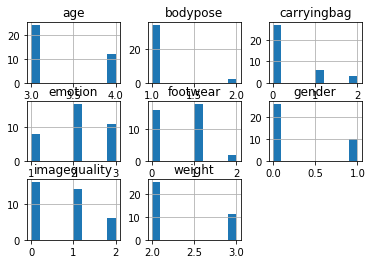

In [26]:
age_df.hist()
plt.show()

In [0]:
mod_df=train_df.append(age_df)
for i in range(100):
  mod_df=mod_df.append(age_df)

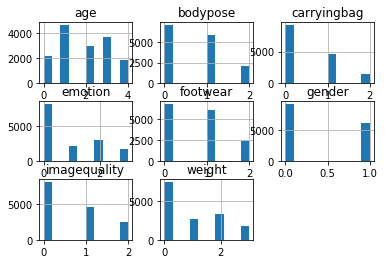

In [28]:
mod_df.hist()
plt.show()

In [0]:
gender_df=mod_df.loc[(mod_df['gender']>=1) & (mod_df['bodypose']>=2) & 
                    (mod_df['emotion']>=1) & (mod_df['age'] !=1) &
                    (mod_df['weight']>=1) ]


1    7
Name: gender, dtype: int64


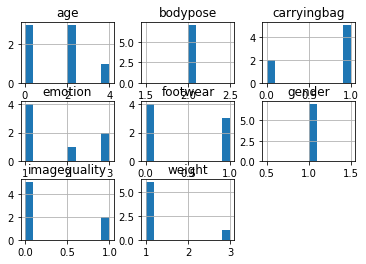

In [30]:
print(gender_df.gender.value_counts())

gender_df.hist()
plt.show()

In [0]:
mod_df1=mod_df.append(gender_df)
for i in range(200):
  mod_df1=mod_df1.append(gender_df)

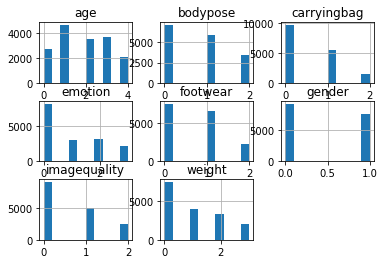

In [32]:
mod_df1.hist()
plt.show()

In [0]:
emotion_df=mod_df.loc[ (mod_df['bodypose']>=2) & 
                    (mod_df['emotion']>=1) & (mod_df['age'] !=1) &
                    (mod_df['weight']>=1) ]


2    109
3    107
1      8
Name: emotion, dtype: int64


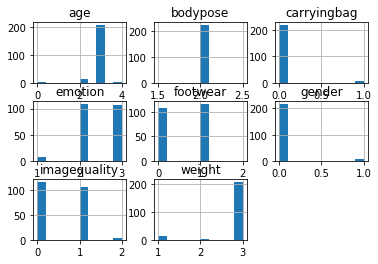

In [34]:
print(emotion_df.emotion.value_counts())

emotion_df.hist()
plt.show()

In [0]:
mod_df2=mod_df1.append(emotion_df)

for i in range(10):
  mod_df2=mod_df2.append(emotion_df)

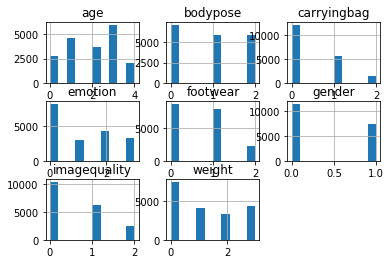

In [36]:
mod_df2.hist()
plt.show()

In [0]:
bag_df=mod_df2.loc[ (mod_df2['carryingbag']>=1) & 
                    (mod_df2['emotion']>=1) & (mod_df2['gender'] !=0) & (mod_df2.age !=3) &
                    (mod_df2['weight']>=1) ]

1    1384
2     150
Name: carryingbag, dtype: int64


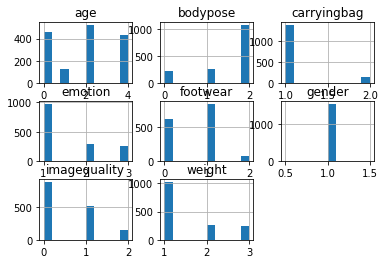

In [38]:
print(bag_df.carryingbag.value_counts())

bag_df.hist()
plt.show()

In [0]:
mod_df3=mod_df2.append(bag_df)

for i in range(1):
  mod_df3=mod_df3.append(bag_df)

mod_df3=mod_df3.append(train_df)  

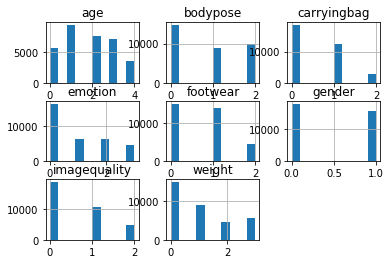

In [40]:
mod_df3.hist()
plt.show()

In [0]:
age_df4=mod_df3.loc[ (mod_df3['age']!=3) & 
                    (mod_df3['emotion']>=1) & (mod_df3['weight'] ==2) & (mod_df3.carryingbag ==2) &
                    (mod_df3['imagequality']>=1) ]

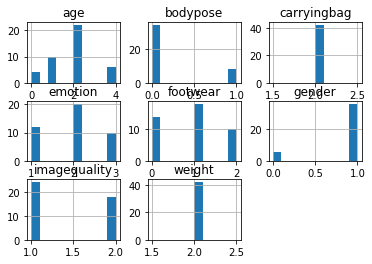

In [42]:
age_df4.hist()
plt.show()

In [0]:
 
mod_df4=mod_df3.append(age_df4)
for i in range(20):
  mod_df4=mod_df4.append(age_df4)

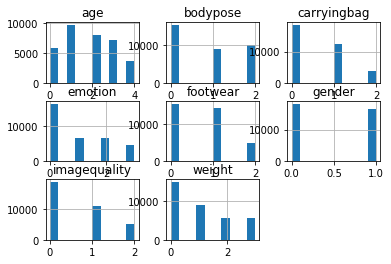

In [44]:
mod_df4.hist()
plt.show()

As we can see , the various combinations still have imbalance in a few categories . We could selectively use some of these oversampled train sets in training 

### Datagenerator - Use ImageDatagenerator 



Since we are not using a one-hot encoded dataset , we can use the Imagedatagenerator class that comes with Keras to generate data for training . We will set the following 

x_col="image_path",

y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],

class_mode='multi_output'


In [45]:
# create train and validation data generators
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        preprocessing_function=norm_mean
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=norm_mean
    )

train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224, 112), interpolation='bicubic',
        batch_size=16,
        class_mode='multi_output')

val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224, 112),interpolation='bicubic',
        batch_size=32,
        class_mode='multi_output')

Found 11537 validated image filenames.
Found 2036 validated image filenames.


### output units to be used for model building 

In [46]:
# get number of output units from data
num_units={}
for col in df.columns:
  if col!='image_path':
    num_units[col]=len(df[col].unique())


print(num_units)

{'gender': 2, 'imagequality': 3, 'age': 5, 'weight': 4, 'carryingbag': 3, 'footwear': 3, 'emotion': 4, 'bodypose': 3}


## Build the model 

Our model will have a main branch for all except age and footwear and two additional branches for age and footwear training 

The Main branch will use the 112x224 image as input where as age branch will use the top half of image (112x112) and footwear branch will use bottom half of image (112x112) 

A simplified view of the model is as below 
![simplified_model](https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/model_simplified_view.png)


We will make use fo Resnet-like layers for the three branches. In general if the dataset was thoroughly checked for annotations and corrected , Emotion and Gender could also  benefit from the face branch. We will add the outputs of the branches in the hope that the individual branches may learn and contribute something extra for a related classification task. Only the training results will tell how well founded this assumption is.

We also make a portion of the conv layers as dilated layers as they may add context to thevarious features found



Code for individual compoinents/layers 

In [47]:
import tensorflow as tf
wt_init = tf.keras.initializers.TruncatedNormal(mean=0.0,stddev=0.02,
                                                          seed=2019)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
import keras
WEIGHT_DECAY=1.25e-4
reg=keras.regularizers.l2(WEIGHT_DECAY)
c_c=0
def conv(inp,f=32,k1=3,k2=3,s1=1,s2=1,padng='same',dilation=False):
  global c_c
  name='conv_'+str(c_c)
  c_c+=1
  if dilation==True:
    conv_layer=Conv2D(f,(k1,k2),strides=(s1,s2),use_bias=False,padding=padng,kernel_initializer=wt_init, kernel_regularizer=reg,dilation_rate=2,name=name)(inp)
  else:
    conv_layer=Conv2D(f,(k1,k2),strides=(s1,s2),use_bias=False,padding=padng,kernel_initializer=wt_init, kernel_regularizer=reg,name=name)(inp)  

  conv_layer=BatchNormalization(momentum=0.9, epsilon=1e-5,name=name+'_bn')(conv_layer)
  #conv_layer=Activation('relu')(conv_layer)
  conv_layer=LeakyReLU(alpha=0.2,name=name+'_lr')(conv_layer)
  conv_layer=Dropout(0.02,name=name+'_drpout')(conv_layer)
  return conv_layer

def reslayer(inp,f=32,dilate=True):
  if dilate==True:
    conv1=conv(inp,3*f//4)  
    conv2=conv(inp,f//4,dilation=True)
    conv1=Concatenate()([conv1,conv2])
    conv1=conv(conv1,f,1,1)

  else:
     conv1=conv(inp,f) 

  return conv1   

def resBlk(inp,f=32,k=3,residual=True,pool=True,dilate=False) :
  res1=reslayer(inp,f,dilate)
  #res2=reslayer(res1,f)  
  if pool:
    res2=MaxPooling2D(pool_size=(2,2))(res1)

  if residual:
    res3=reslayer(res2,f,dilate)
    res4=reslayer(res3,f)
    
    return Add()([res2,res4])
  else:
    return res2 

Code for Head of the model . All heads have softmax as activation - even gender which we will treat as a categorical classification (instead of binary)

In [0]:
def build_head(name, in_layer,add_dense=True):

   
  if add_dense:
    last_layer=  Dense(64, kernel_initializer=wt_init, use_bias=False,kernel_regularizer=reg)(in_layer)
    last_layer= BatchNormalization(momentum=0.9, epsilon=1e-5)(last_layer)
    last_layer= LeakyReLU(alpha=0.2,name=name+'_head_last_lr')(last_layer)
    #last_layer=  Dense(64, kernel_initializer=wt_init,use_bias=False,kernel_regularizer=reg)(last_layer)
    
  else:
    last_layer=in_layer 

  last_layer =Dense(num_units[name], use_bias=False,kernel_initializer=wt_init)(last_layer)   
  #last_layer=Lambda(lambda x: x*0.125)(last_layer)
  out=Activation('softmax',name=f"{name}_output") (last_layer)
  return out 

  

### Main branch

In [0]:
def build_main_branch(inp,f):
  layer1=conv(inp,f,k1=3,k2=3,s1=1,s2=1,padng='same')
  layer1=conv(layer1,f,k1=3,k2=3,s1=1,s2=1,padng='same')
  
  
  
  layer2=conv(layer1,f,k1=3,k2=3,s1=1,s2=1,padng='same',dilation=True)
  
  

  layer1=Concatenate()([layer1,layer2])
  
  
  layer1=conv(layer1,f,k1=1,k2=1,s1=1,s2=1,padng='same')

  res1=resBlk(layer1,f*2,3,True,True,True)
  res2=resBlk(res1,f*4,3,False,True,True)
  res3=resBlk(res2,f*4,3)
  res4=resBlk(res3,f*8,3)
  

  last_block=conv(res4,f*16,k1=3,k2=3,s1=2,s2=1,padng='same')
  last_block=Conv2D(f*8,1,use_bias=False,kernel_initializer=wt_init, kernel_regularizer=reg)(last_block)
  last_block= BatchNormalization(momentum=0.9, epsilon=1e-5)(last_block)
  last_block= LeakyReLU(alpha=0.2,name='main_last_lr')(last_block)
  layer2=GlobalAveragePooling2D()(last_block)

  
  
  
  
  
  return layer2

Code for cropping top and bottom portions of input image 

In [0]:
def crop_top1(img):
  #print(type(img))
  #print('shape',shp)
  h1=img.shape[1]//2
  
  return img[:,0:h1,:,:]

In [0]:
def crop_botm1(img):
  #print(type(img))
  #print('shape',shp)
  h1=img.shape[1]//2
  
  return img[:,h1:,:,:]

### age branch

In [0]:


def build_age_branch(inp,f) :
  
  layer1=conv(inp,f,k1=3,k2=3,s1=1,s2=1,padng='same')
  layer1=conv(layer1,f,k1=3,k2=3,s1=1,s2=1,padng='same')
  
  layer2=conv(layer1,f,k1=3,k2=3,s1=1,s2=1,padng='same',dilation=True)
  
  layer1=Concatenate()([layer1,layer2])
  
  layer1=conv(layer1,f,k1=1,k2=1,s1=1,s2=1,padng='same')

  res1=resBlk(layer1,f*2,3,True,True,True)
  res2=resBlk(res1,f*4,3,False,True,True)
  res3=resBlk(res2,f*4,3)
  res4=resBlk(res3,f*8,3)
  

  last_block=conv(res4,f*16,k1=3,k2=3,s1=1,s2=1,padng='same')
  last_block=Conv2D(f*8,1,use_bias=False,kernel_initializer=wt_init, kernel_regularizer=reg)(last_block)
  last_block= BatchNormalization(momentum=0.9, epsilon=1e-5)(last_block)
  last_block= LeakyReLU(alpha=0.2,name='age_last_lr')(last_block)
  layer2=GlobalAveragePooling2D()(last_block)
  return layer2

### foot branch

In [0]:


def build_foot_branch(inp,f):
  
  layer1=conv(inp,f,k1=3,k2=3,s1=1,s2=1,padng='same')
  layer1=conv(layer1,f,k1=3,k2=3,s1=1,s2=1,padng='same')
  
  layer2=conv(layer1,f,k1=3,k2=3,s1=1,s2=1,padng='same',dilation=True)
  
  layer1=Concatenate()([layer1,layer2])
  layer1=conv(layer1,f,k1=1,k2=1,s1=1,s2=1,padng='same')

  res1=resBlk(layer1,f*2,3,True,True,True)
  res2=resBlk(res1,f*4,3,False,True,True)
  res3=resBlk(res2,f*4,3)
  res4=resBlk(res3,f*8,3)
  

  last_block=conv(res4,f*16,k1=3,k2=3,s1=1,s2=1,padng='same')
  last_block=Conv2D(f*8,1,use_bias=False,kernel_initializer=wt_init, kernel_regularizer=reg)(last_block)
  last_block= BatchNormalization(momentum=0.9, epsilon=1e-5)(last_block)
  last_block= LeakyReLU(alpha=0.2,name='foot_last_lr')(last_block)
  layer2=GlobalAveragePooling2D()(last_block)
  
  return layer2

### build model 
We keep the input size open for different size image batches as this would allow us to train on different variations of the input image sizes e.g 112x224 , 56x112 , etc  

In [0]:
def build_model():
  f=16
  global c_c
  c_c=0 # used for naming the conv layers
  inp=Input(shape=(None,None,3))
  #inp1=Lambda(lambda x:standardize(x))(inp)
  inp2=Lambda(lambda x:crop_top1(x))(inp)
  inp3=Lambda(lambda x:crop_botm1(x))(inp)
  main_branch=build_main_branch(inp,f)
  age_branch=build_age_branch(inp2,f)
  foot_branch=build_foot_branch(inp3,f)


  main_branch1=Add()([main_branch,age_branch,foot_branch])

  main_branch2=Add()([main_branch,age_branch])

  main_branch3=Add()([main_branch,foot_branch])
  

  gender = build_head("gender", main_branch1)
  image_quality = build_head("imagequality", main_branch1)
  
  age = build_head("age", main_branch2)
  weight = build_head("weight", main_branch1)
  bag = build_head("carryingbag", main_branch1)
  
  footwear = build_head("footwear", main_branch3)
  
  emotion = build_head("emotion", main_branch2)
  pose = build_head("bodypose", main_branch)
  model=Model(inputs=[inp],outputs=[gender,image_quality,age,weight,bag,footwear,emotion,pose])
  
  model.summary()
  return model 

In [0]:
model=build_model()









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 1 432         in

Plot the model 

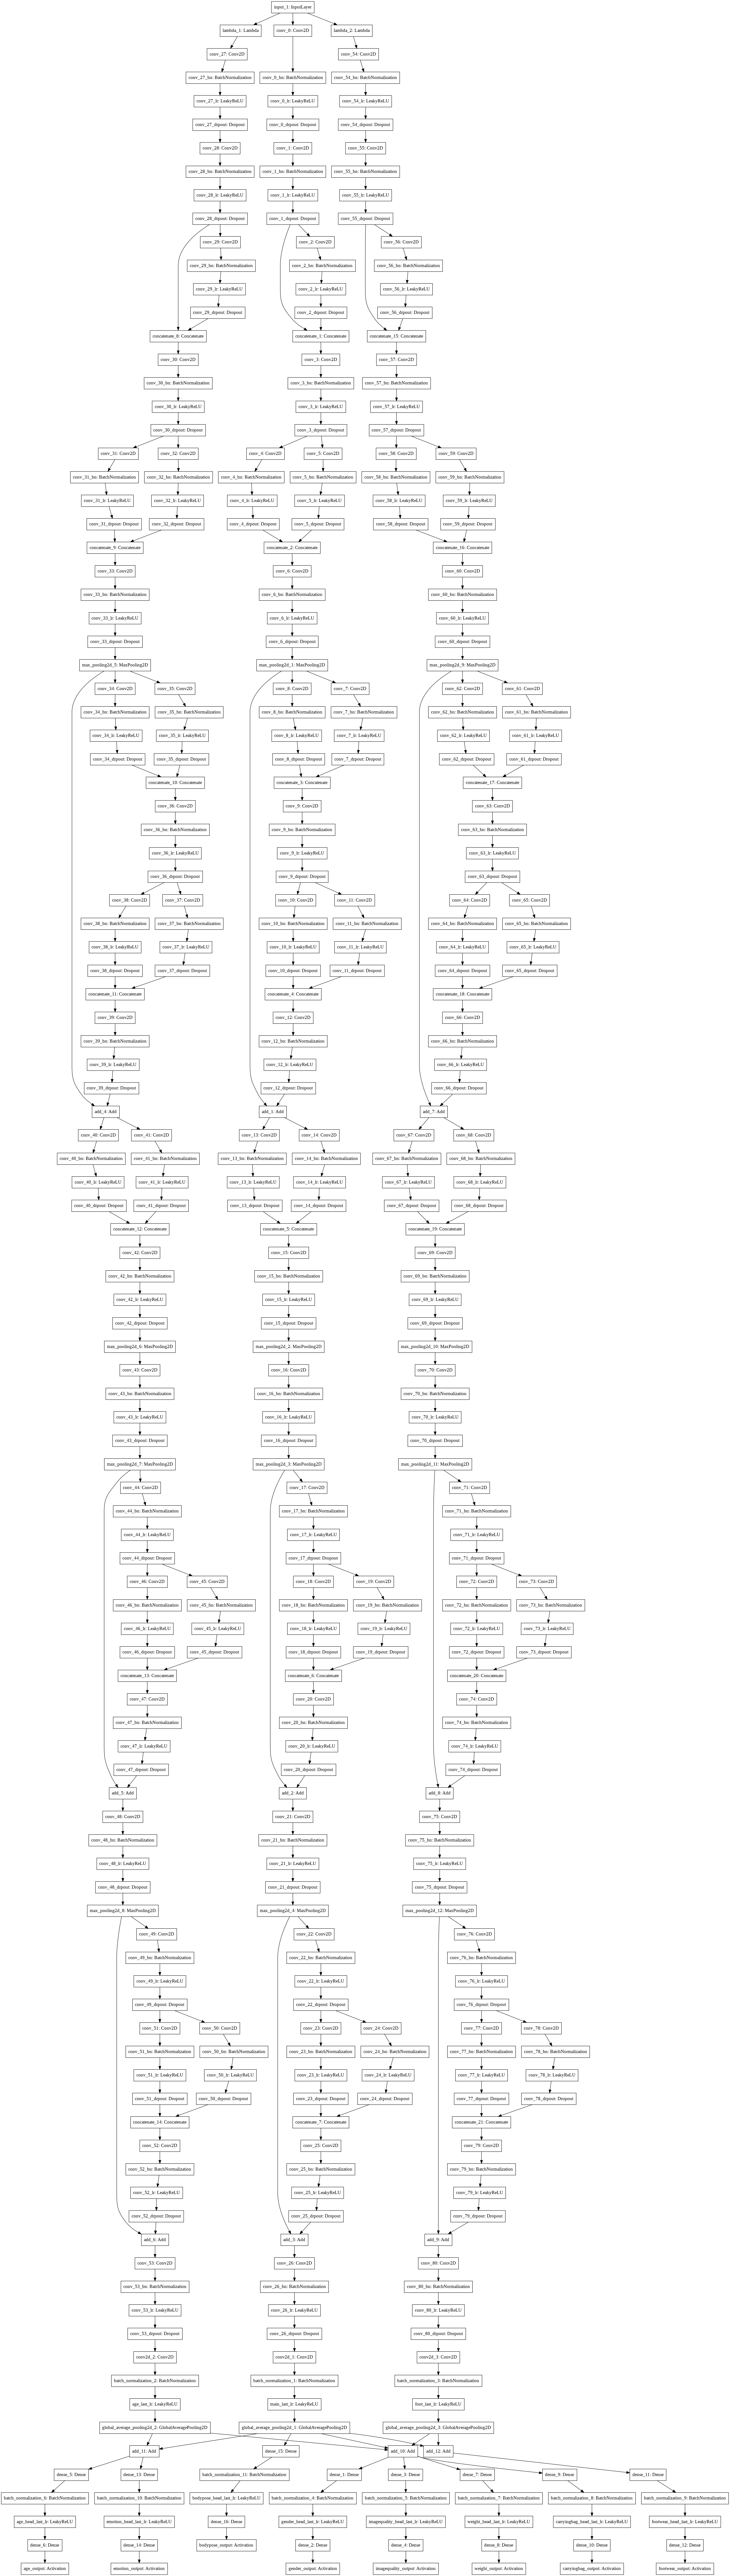

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image, display
display(Image('model.png'))

In [0]:
#conv_26,conv_26_bn,conv_26_lr,conv_26_drpout,conv2d_1,batch_normalization_1,main_last_lr,global_average_pooling2d_1,concatenate_5,add_3,max_pooling2d_1to4

### Training 
We will use SGD as the optimizer , momentum of 0.9 and nesterov True 
Train for a few epochs with a learning rate of 0.0001 with different input image sizes 

In [0]:

opt = SGD(lr=0.0001, momentum=0.9,nesterov=True)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    
    metrics=['accuracy']
)

### Model checkpoint to save best model . We track the gender validation accuracy to save our models . 

### If there wasn't any space contraint in google drive, an ideal way would be to save model for each epoch since we are looking for a training run that has the best combination of val accuracies and not gender accuracy alone . 

In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path="/content/gdrive/My Drive/EIP4/session5/best_model3-{epoch:03d}.h5"


chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_gender_output_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [0]:
# create train and validation data generators
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        preprocessing_function=norm_mean
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=norm_mean
    )

train_gen1 = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(112, 56), interpolation='bicubic',
        batch_size=32,
        class_mode='multi_output')

val_gen1 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(112, 56),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

Found 11537 validated image filenames.
Found 2036 validated image filenames.


First 2 epochs

In [0]:
model.fit_generator(
    generator=train_gen1,
    validation_data=val_gen1,
     
    epochs=2,callbacks=[chkpoint_model],
    verbose=1
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
361/361 [==============================] - 106s 293ms/step - loss: 8.8340 - gender_output_loss: 0.6760 - imagequality_output_loss: 1.0438 - age_output_loss: 1.5383 - weight_output_loss: 1.2059 - carryingbag_output_loss: 1.0282 - footwear_output_loss: 1.0686 - emotion_output_loss: 1.1547 - bodypose_output_loss: 1.0140 - gender_output_acc: 0.5811 - imagequality_output_acc: 0.5088 - age_output_acc: 0.3493 - weight_output_acc: 0.6106 - carryingbag_output_acc: 0.5140 - footwear_output_acc: 0.4384 - emotion_output_acc: 0.6815 - bodypose_output_acc: 0.5672 - val_loss: 8.2469 - val_gender_output_loss: 0.6639 - val_imagequality_output_loss: 1.0404 - val_age_output_loss: 1.4829 - val_weight_output_loss: 1.0853 - val_carryingbag_output_loss: 0.9363 - val_footwear_output_loss: 1.0381 - val_emotion_output_loss: 0.9516 - val_bodypose_output_loss: 0.9439 - val_gender_output_acc: 0.6125 - val_imag

In [0]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        preprocessing_function=norm_mean
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=norm_mean
    )

train_gen2 = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112), interpolation='bicubic',
        batch_size=32,
        class_mode='multi_output')

val_gen2 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

Found 11537 validated image filenames.
Found 2036 validated image filenames.


Epochs 3 and 4

In [0]:
model.fit_generator(
    generator=train_gen2,
    validation_data=val_gen2,
     
    epochs=2,callbacks=[chkpoint_model],
    verbose=1
)

Epoch 1/2
361/361 [==============================] - 209s 580ms/step - loss: 7.8235 - gender_output_loss: 0.6237 - imagequality_output_loss: 0.9610 - age_output_loss: 1.4378 - weight_output_loss: 1.0115 - carryingbag_output_loss: 0.9102 - footwear_output_loss: 0.9430 - emotion_output_loss: 0.9312 - bodypose_output_loss: 0.9005 - gender_output_acc: 0.6492 - imagequality_output_acc: 0.5573 - age_output_acc: 0.3986 - weight_output_acc: 0.6374 - carryingbag_output_acc: 0.5719 - footwear_output_acc: 0.5667 - emotion_output_acc: 0.7124 - bodypose_output_acc: 0.6179 - val_loss: 7.9610 - val_gender_output_loss: 0.6632 - val_imagequality_output_loss: 1.0355 - val_age_output_loss: 1.4398 - val_weight_output_loss: 1.0107 - val_carryingbag_output_loss: 0.9222 - val_footwear_output_loss: 0.9411 - val_emotion_output_loss: 0.9423 - val_bodypose_output_loss: 0.9015 - val_gender_output_acc: 0.6051 - val_imagequality_output_acc: 0.5334 - val_age_output_acc: 0.3934 - val_weight_output_acc: 0.6257 - val_c

Epochs 5-10

In [0]:
model.fit_generator(
    generator=train_gen1,
    validation_data=val_gen1,
     
    epochs=10,callbacks=[chkpoint_model],initial_epoch=4,
    verbose=1
)

Epoch 5/10
361/361 [==============================] - 76s 212ms/step - loss: 7.4731 - gender_output_loss: 0.5758 - imagequality_output_loss: 0.9476 - age_output_loss: 1.4049 - weight_output_loss: 0.9768 - carryingbag_output_loss: 0.8838 - footwear_output_loss: 0.8651 - emotion_output_loss: 0.9027 - bodypose_output_loss: 0.8116 - gender_output_acc: 0.6898 - imagequality_output_acc: 0.5580 - age_output_acc: 0.4012 - weight_output_acc: 0.6376 - carryingbag_output_acc: 0.5858 - footwear_output_acc: 0.6143 - emotion_output_acc: 0.7122 - bodypose_output_acc: 0.6493 - val_loss: 7.5456 - val_gender_output_loss: 0.5781 - val_imagequality_output_loss: 1.0143 - val_age_output_loss: 1.4197 - val_weight_output_loss: 0.9951 - val_carryingbag_output_loss: 0.8820 - val_footwear_output_loss: 0.8554 - val_emotion_output_loss: 0.9106 - val_bodypose_output_loss: 0.7859 - val_gender_output_acc: 0.6916 - val_imagequality_output_acc: 0.5363 - val_age_output_acc: 0.3944 - val_weight_output_acc: 0.6257 - val_c

Change augmentation function after 10 epochs 

In [0]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        
        preprocessing_function=img_aug3,zoom_range=[0.9,1.2]
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=norm_mean
    )

train_gen1 = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(112,56), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=48,
        class_mode='multi_output')

val_gen1 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(112,56),interpolation='bicubic',
        batch_size=96,
        class_mode='multi_output')

train_gen2 = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=32,
        class_mode='multi_output')

val_gen2 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

train_gen3 = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(84,42), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=64,
        class_mode='multi_output')

val_gen3 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(84,42),interpolation='bicubic',
        batch_size=128,
        class_mode='multi_output')

train_gen4 = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(168,84), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=32,
        class_mode='multi_output')

val_gen4 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(168,84),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

Found 11537 validated image filenames.
Found 2036 validated image filenames.
Found 11537 validated image filenames.
Found 2036 validated image filenames.
Found 11537 validated image filenames.
Found 2036 validated image filenames.
Found 11537 validated image filenames.
Found 2036 validated image filenames.


Epoch 11-20

In [0]:
model.fit_generator(
    generator=train_gen1,
    validation_data=val_gen1,
     
    epochs=20,callbacks=[chkpoint_model],initial_epoch=10,
    verbose=1
)

Epoch 11/20
241/241 [==============================] - 68s 283ms/step - loss: 7.4732 - gender_output_loss: 0.5711 - imagequality_output_loss: 0.9390 - age_output_loss: 1.3917 - weight_output_loss: 0.9697 - carryingbag_output_loss: 0.8688 - footwear_output_loss: 0.9139 - emotion_output_loss: 0.8963 - bodypose_output_loss: 0.8179 - gender_output_acc: 0.7039 - imagequality_output_acc: 0.5613 - age_output_acc: 0.4032 - weight_output_acc: 0.6374 - carryingbag_output_acc: 0.5979 - footwear_output_acc: 0.5801 - emotion_output_acc: 0.7125 - bodypose_output_acc: 0.6461 - val_loss: 7.1683 - val_gender_output_loss: 0.5152 - val_imagequality_output_loss: 0.9244 - val_age_output_loss: 1.4060 - val_weight_output_loss: 0.9968 - val_carryingbag_output_loss: 0.8629 - val_footwear_output_loss: 0.8126 - val_emotion_output_loss: 0.9011 - val_bodypose_output_loss: 0.6445 - val_gender_output_acc: 0.7417 - val_imagequality_output_acc: 0.5535 - val_age_output_acc: 0.3905 - val_weight_output_acc: 0.6248 - val_

Epoch 21-30

In [0]:
model.fit_generator(
    generator=train_gen2,
    validation_data=val_gen2,
     
    epochs=30,callbacks=[chkpoint_model],initial_epoch=20,
    verbose=1
)

Epoch 21/30
361/361 [==============================] - 207s 573ms/step - loss: 7.3858 - gender_output_loss: 0.5482 - imagequality_output_loss: 0.9029 - age_output_loss: 1.3936 - weight_output_loss: 0.9687 - carryingbag_output_loss: 0.8667 - footwear_output_loss: 0.8907 - emotion_output_loss: 0.8955 - bodypose_output_loss: 0.8148 - gender_output_acc: 0.7169 - imagequality_output_acc: 0.5661 - age_output_acc: 0.4006 - weight_output_acc: 0.6371 - carryingbag_output_acc: 0.6028 - footwear_output_acc: 0.5917 - emotion_output_acc: 0.7124 - bodypose_output_acc: 0.6517 - val_loss: 7.3082 - val_gender_output_loss: 0.5350 - val_imagequality_output_loss: 0.9200 - val_age_output_loss: 1.4054 - val_weight_output_loss: 0.9963 - val_carryingbag_output_loss: 0.8648 - val_footwear_output_loss: 0.8483 - val_emotion_output_loss: 0.9124 - val_bodypose_output_loss: 0.7211 - val_gender_output_acc: 0.7348 - val_imagequality_output_acc: 0.5511 - val_age_output_acc: 0.3895 - val_weight_output_acc: 0.6238 - val

EPOCH 31-40

In [0]:
model.fit_generator(
    generator=train_gen4,
    validation_data=val_gen4,
     
    epochs=40,callbacks=[chkpoint_model],initial_epoch=30,
    verbose=1
)

Epoch 31/40
361/361 [==============================] - 131s 363ms/step - loss: 6.9599 - gender_output_loss: 0.4557 - imagequality_output_loss: 0.8908 - age_output_loss: 1.3685 - weight_output_loss: 0.9505 - carryingbag_output_loss: 0.8259 - footwear_output_loss: 0.8456 - emotion_output_loss: 0.8752 - bodypose_output_loss: 0.6428 - gender_output_acc: 0.7788 - imagequality_output_acc: 0.5764 - age_output_acc: 0.4029 - weight_output_acc: 0.6398 - carryingbag_output_acc: 0.6339 - footwear_output_acc: 0.6175 - emotion_output_acc: 0.7124 - bodypose_output_acc: 0.7298 - val_loss: 6.8354 - val_gender_output_loss: 0.4160 - val_imagequality_output_loss: 0.8923 - val_age_output_loss: 1.3936 - val_weight_output_loss: 0.9933 - val_carryingbag_output_loss: 0.8200 - val_footwear_output_loss: 0.8006 - val_emotion_output_loss: 0.8825 - val_bodypose_output_loss: 0.5321 - val_gender_output_acc: 0.8089 - val_imagequality_output_acc: 0.5766 - val_age_output_acc: 0.4013 - val_weight_output_acc: 0.6194 - val

Epoch 41-50

In [0]:
model.fit_generator(
    generator=train_gen3,
    validation_data=val_gen3,
     
    epochs=50,callbacks=[chkpoint_model],initial_epoch=40,
    verbose=1
)

Epoch 41/50
181/181 [==============================] - 45s 249ms/step - loss: 7.3024 - gender_output_loss: 0.5313 - imagequality_output_loss: 0.9340 - age_output_loss: 1.3786 - weight_output_loss: 0.9587 - carryingbag_output_loss: 0.8568 - footwear_output_loss: 0.8915 - emotion_output_loss: 0.8856 - bodypose_output_loss: 0.7609 - gender_output_acc: 0.7376 - imagequality_output_acc: 0.5664 - age_output_acc: 0.4039 - weight_output_acc: 0.6367 - carryingbag_output_acc: 0.6102 - footwear_output_acc: 0.5904 - emotion_output_acc: 0.7125 - bodypose_output_acc: 0.6832 - val_loss: 6.9862 - val_gender_output_loss: 0.4470 - val_imagequality_output_loss: 0.9442 - val_age_output_loss: 1.3892 - val_weight_output_loss: 0.9903 - val_carryingbag_output_loss: 0.8290 - val_footwear_output_loss: 0.8277 - val_emotion_output_loss: 0.8834 - val_bodypose_output_loss: 0.5705 - val_gender_output_acc: 0.7859 - val_imagequality_output_acc: 0.5422 - val_age_output_acc: 0.3983 - val_weight_output_acc: 0.6272 - val_

In [0]:
def img_aug6(img):
  img=standardize(img)
  
  img=random_pad_crop_img(img)
  img=cutout2(img)
  img=h_flip(img,prob=50)
  
  return img      

In [0]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        
        preprocessing_function=img_aug3
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=norm_mean
    )

train_gen1 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(112,56), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=48,
        class_mode='multi_output')

val_gen1 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(112,56),interpolation='bicubic',
        batch_size=96,
        class_mode='multi_output')

train_gen2 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=32,
        class_mode='multi_output')

val_gen2 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

train_gen3 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(84,42), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=64,
        class_mode='multi_output')

val_gen3 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(84,42),interpolation='bicubic',
        batch_size=128,
        class_mode='multi_output')

train_gen4 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(168,84), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=32,
        class_mode='multi_output')

val_gen4 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(168,84),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

Found 16580 validated image filenames.
Found 2036 validated image filenames.
Found 16580 validated image filenames.
Found 2036 validated image filenames.
Found 16580 validated image filenames.
Found 2036 validated image filenames.
Found 16580 validated image filenames.
Found 2036 validated image filenames.


Load Best model after 50 epochs and continue training

In [0]:
from keras.models import load_model

cust = {'crop_top1': crop_top1, 'crop_botm1': crop_botm1}
model=load_model('/content/gdrive/My Drive/EIP4/session5/best_model3-039.h5',cust)

In [0]:

opt = SGD(lr=0.001, momentum=0.9,nesterov=True)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    
    metrics=['accuracy']
)

In [0]:
def scheduler2(epoch):
  lr=np.interp([epoch],[EPOCHS-50,EPOCHS-40,EPOCHS-30,EPOCHS-20,EPOCHS-10,EPOCHS], [0.001, 0.00095,0.0008,0.0007,0.0006,0.0005])[0]
  print('epoch ', epoch+1, ': setting learning rate to ',lr)
  return lr


lr_callback2 = keras.callbacks.LearningRateScheduler(scheduler2)

Epoch 51-100

In [0]:
EPOCHS=100
model.fit_generator(
    generator=train_gen1,
    validation_data=val_gen1,
     
    epochs=EPOCHS,callbacks=[chkpoint_model,lr_callback2],initial_epoch=50,
    verbose=2
)

Epoch 51/100
epoch  51 : setting learning rate to  0.001
 - 130s - loss: 6.8189 - gender_output_loss: 0.4310 - imagequality_output_loss: 0.8237 - age_output_loss: 1.3062 - weight_output_loss: 1.0104 - carryingbag_output_loss: 0.7210 - footwear_output_loss: 0.7412 - emotion_output_loss: 1.0055 - bodypose_output_loss: 0.6743 - gender_output_acc: 0.7952 - imagequality_output_acc: 0.6239 - age_output_acc: 0.4594 - weight_output_acc: 0.6096 - carryingbag_output_acc: 0.6864 - footwear_output_acc: 0.6794 - emotion_output_acc: 0.6290 - bodypose_output_acc: 0.7177 - val_loss: 7.5923 - val_gender_output_loss: 0.5196 - val_imagequality_output_loss: 1.0273 - val_age_output_loss: 1.4882 - val_weight_output_loss: 1.0703 - val_carryingbag_output_loss: 0.8943 - val_footwear_output_loss: 0.8761 - val_emotion_output_loss: 0.9666 - val_bodypose_output_loss: 0.6436 - val_gender_output_acc: 0.7593 - val_imagequality_output_acc: 0.5309 - val_age_output_acc: 0.3389 - val_weight_output_acc: 0.5717 - val_carry

Epoch 101-150

In [0]:
EPOCHS=150
model.fit_generator(
    generator=train_gen4,
    validation_data=val_gen4,
     
    epochs=EPOCHS,callbacks=[chkpoint_model,lr_callback2],initial_epoch=100,
    verbose=1
)

Epoch 101/150
epoch  101 : setting learning rate to  0.001
519/519 [==============================] - 184s 354ms/step - loss: 5.0117 - gender_output_loss: 0.3046 - imagequality_output_loss: 0.6444 - age_output_loss: 0.9841 - weight_output_loss: 0.6870 - carryingbag_output_loss: 0.5717 - footwear_output_loss: 0.6029 - emotion_output_loss: 0.6584 - bodypose_output_loss: 0.4342 - gender_output_acc: 0.8612 - imagequality_output_acc: 0.7010 - age_output_acc: 0.5796 - weight_output_acc: 0.7359 - carryingbag_output_acc: 0.7570 - footwear_output_acc: 0.7380 - emotion_output_acc: 0.7778 - bodypose_output_acc: 0.8280 - val_loss: 6.8313 - val_gender_output_loss: 0.3835 - val_imagequality_output_loss: 0.9075 - val_age_output_loss: 1.4135 - val_weight_output_loss: 0.9776 - val_carryingbag_output_loss: 0.8292 - val_footwear_output_loss: 0.8149 - val_emotion_output_loss: 0.9179 - val_bodypose_output_loss: 0.4622 - val_gender_output_acc: 0.8237 - val_imagequality_output_acc: 0.5707 - val_age_output_ac

Runtine disconnected at epch 110 and so we will load last saved model and continue training 

In [0]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        
        preprocessing_function=img_aug3
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=norm_mean
    )

train_gen1 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(112,56), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=48,
        class_mode='multi_output')

val_gen1 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(112,56),interpolation='bicubic',
        batch_size=96,
        class_mode='multi_output')

train_gen2 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=32,
        class_mode='multi_output')

val_gen2 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

train_gen3 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(84,42), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=64,
        class_mode='multi_output')

val_gen3 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(84,42),interpolation='bicubic',
        batch_size=128,
        class_mode='multi_output')

train_gen4 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(168,84), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=32,
        class_mode='multi_output')

val_gen4 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(168,84),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

Found 16580 validated image filenames.
Found 2036 validated image filenames.
Found 16580 validated image filenames.
Found 2036 validated image filenames.
Found 16580 validated image filenames.
Found 2036 validated image filenames.
Found 16580 validated image filenames.
Found 2036 validated image filenames.


In [0]:
from keras.models import load_model

cust = {'crop_top1': crop_top1, 'crop_botm1': crop_botm1}
model=load_model('/content/gdrive/My Drive/EIP4/session5/best_model3-110.h5',cust)










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:

opt = SGD(lr=0.001, momentum=0.9,nesterov=True)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    
    metrics=['accuracy']
)

In [0]:
def scheduler2(epoch):
  lr=np.interp([epoch],[EPOCHS-50,EPOCHS-40,EPOCHS-30,EPOCHS-20,EPOCHS-10,EPOCHS], [0.001, 0.00095,0.0008,0.0007,0.0006,0.0005])[0]
  print('epoch ', epoch+1, ': setting learning rate to ',lr)
  return lr


lr_callback2 = keras.callbacks.LearningRateScheduler(scheduler2)

In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path="/content/gdrive/My Drive/EIP4/session5/best_model3-{epoch:03d}.h5"


chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_gender_output_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

Epoch 111-150

In [0]:
EPOCHS=150
model.fit_generator(
    generator=train_gen4,
    validation_data=val_gen4,
     
    epochs=EPOCHS,callbacks=[chkpoint_model,lr_callback2],initial_epoch=110,
    verbose=1
)

Epoch 111/150
epoch  111 : setting learning rate to  0.00095
519/519 [==============================] - 218s 421ms/step - loss: 4.2359 - gender_output_loss: 0.2098 - imagequality_output_loss: 0.5703 - age_output_loss: 0.8731 - weight_output_loss: 0.5697 - carryingbag_output_loss: 0.4884 - footwear_output_loss: 0.5202 - emotion_output_loss: 0.5673 - bodypose_output_loss: 0.3028 - gender_output_acc: 0.9088 - imagequality_output_acc: 0.7334 - age_output_acc: 0.6221 - weight_output_acc: 0.7730 - carryingbag_output_acc: 0.7933 - footwear_output_acc: 0.7698 - emotion_output_acc: 0.8019 - bodypose_output_acc: 0.8842 - val_loss: 6.6338 - val_gender_output_loss: 0.3133 - val_imagequality_output_loss: 0.9274 - val_age_output_loss: 1.3338 - val_weight_output_loss: 0.9576 - val_carryingbag_output_loss: 0.8252 - val_footwear_output_loss: 0.8178 - val_emotion_output_loss: 0.9114 - val_bodypose_output_loss: 0.4127 - val_gender_output_acc: 0.8787 - val_imagequality_output_acc: 0.5575 - val_age_output_

Epoch 151-200

In [0]:
EPOCHS=200
model.fit_generator(
    generator=train_gen2,
    validation_data=val_gen2,
     
    epochs=EPOCHS,callbacks=[chkpoint_model,lr_callback2],initial_epoch=150,
    verbose=2
)

Epoch 151/200
epoch  151 : setting learning rate to  0.001
 - 295s - loss: 4.2572 - gender_output_loss: 0.2101 - imagequality_output_loss: 0.5647 - age_output_loss: 0.8582 - weight_output_loss: 0.5717 - carryingbag_output_loss: 0.4757 - footwear_output_loss: 0.5244 - emotion_output_loss: 0.5662 - bodypose_output_loss: 0.3247 - gender_output_acc: 0.9112 - imagequality_output_acc: 0.7396 - age_output_acc: 0.6334 - weight_output_acc: 0.7720 - carryingbag_output_acc: 0.8000 - footwear_output_acc: 0.7735 - emotion_output_acc: 0.7985 - bodypose_output_acc: 0.8719 - val_loss: 7.1212 - val_gender_output_loss: 0.3530 - val_imagequality_output_loss: 0.9590 - val_age_output_loss: 1.4229 - val_weight_output_loss: 1.0535 - val_carryingbag_output_loss: 0.8762 - val_footwear_output_loss: 0.8647 - val_emotion_output_loss: 0.9932 - val_bodypose_output_loss: 0.4361 - val_gender_output_acc: 0.8590 - val_imagequality_output_acc: 0.5437 - val_age_output_acc: 0.4273 - val_weight_output_acc: 0.6066 - val_car

### Load best model after 200 epochs and evaluate against the validation data . 

In [0]:
from keras.models import load_model

cust = {'crop_top1': crop_top1, 'crop_botm1': crop_botm1}
model=load_model('/content/gdrive/My Drive/EIP4/session5/best_model3-175.h5',cust)

In [0]:
score=model.evaluate_generator(val_gen2,verbose=1)

32/32 [==============================] - 9s 273ms/step


In [0]:
def evaluate_model(model,val_gen):
  results = model.evaluate_generator(val_gen)
  accuracies = {}
  losses = {}
  for k, v in zip(model.metrics_names, results):
    if k.endswith('acc'):
      accuracies[k] = round(v * 100, 4) 
    else:
      losses[k] = v
  #print(accuracies)    
  return accuracies

## Training Result : Accuracy Values for model saved at 175th epoch

In [0]:
evaluate_model(model,val_gen2)

{'age_output_acc': 38.3595,
 'bodypose_output_acc': 85.7564,
 'carryingbag_output_acc': 63.556,
 'emotion_output_acc': 66.2083,
 'footwear_output_acc': 62.6228,
 'gender_output_acc': 89.4892,
 'imagequality_output_acc': 54.7642,
 'weight_output_acc': 57.6621}

The above is the result for the model saved at 175th epoch . At some epochs the gae acuracy reached around 43% but we did not save the model at this epoch as we were tracking gender accuracy.

Epoch 112 results seem to be a good combination 
val_gender_output_acc: 0.8399 - 
val_imagequality_output_acc: 0.5560 - 
val_age_output_acc: 0.4332 - 
val_weight_output_acc: 0.6100 - 
val_carryingbag_output_acc: 0.6483 - 
val_footwear_output_acc: 0.6356 - 
val_emotion_output_acc: 0.7019 - 
val_bodypose_output_acc: 0.8433

But unfortunately we did not save this model as we were monitoring only improvements in gender accuracy

### Some Final experiments 

Train the model for another 20 epochs but this time track 'age' val accuracy.

In [55]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        preprocessing_function=img_aug3
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=norm_mean
    )
train_gen2 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=32,
        class_mode='multi_output')

val_gen2 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

Found 16580 validated image filenames.
Found 2036 validated image filenames.


In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path="/content/gdrive/My Drive/EIP4/session5/best_model3-{epoch:03d}.h5"


chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_age_output_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [0]:

opt = SGD(lr=0.0005, momentum=0.9,nesterov=True)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    
    metrics=['accuracy']
)

In [0]:
EPOCHS=220
model.fit_generator(
    generator=train_gen2,
    validation_data=val_gen2,
     
    epochs=EPOCHS,callbacks=[chkpoint_model],initial_epoch=200,
    verbose=2
)

Epoch 201/220
 - 324s - loss: 2.5893 - gender_output_loss: 0.0669 - imagequality_output_loss: 0.3658 - age_output_loss: 0.5676 - weight_output_loss: 0.3000 - carryingbag_output_loss: 0.2368 - footwear_output_loss: 0.3364 - emotion_output_loss: 0.3775 - bodypose_output_loss: 0.1460 - gender_output_acc: 0.9761 - imagequality_output_acc: 0.8430 - age_output_acc: 0.7707 - weight_output_acc: 0.8814 - carryingbag_output_acc: 0.9064 - footwear_output_acc: 0.8608 - emotion_output_acc: 0.8544 - bodypose_output_acc: 0.9477 - val_loss: 7.6943 - val_gender_output_loss: 0.3351 - val_imagequality_output_loss: 1.1092 - val_age_output_loss: 1.5067 - val_weight_output_loss: 1.1855 - val_carryingbag_output_loss: 1.0013 - val_footwear_output_loss: 0.8828 - val_emotion_output_loss: 1.0677 - val_bodypose_output_loss: 0.4135 - val_gender_output_acc: 0.8841 - val_imagequality_output_acc: 0.5452 - val_age_output_acc: 0.3915 - val_weight_output_acc: 0.5786 - val_carryingbag_output_acc: 0.6434 - val_footwear_ou

Age accuracy increased to 40.815 from the last saved 175-epochs model but the other accuracies seem lesser than before



Some more experiments like setting a specific branch like main branch to non-trainable can be done to see if validation accuracy improves 

In [0]:
from keras.models import load_model

cust = {'crop_top1': crop_top1, 'crop_botm1': crop_botm1}
model=load_model('/content/gdrive/My Drive/EIP4/session5/best_model3-192.h5',cust)

In [0]:

opt = SGD(lr=0.001, momentum=0.9,nesterov=True)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    
    metrics=['accuracy']
)

In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path="/content/gdrive/My Drive/EIP4/session5/best_model3-{epoch:03d}.h5"


chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_age_output_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

### Freeze main branch layers by setting trainable to false and train the other two branches 

In [0]:
def deactivate_main(model):
  layer_names=[]
  for i in range(0,27):
    layer_names.append('conv_'+str(i))
    layer_names.append('conv_'+str(i)+'_bn')
    layer_names.append('conv_'+str(i)+'_lr')
    layer_names.append('conv_'+str(i)+'_drpout')
  #print(layer_names) 
  for i in range(1,6):
    layer_names.append('concatenate_'+str(i))
  for i in range(1,4):
    layer_names.append('add_'+str(i)) 

  for i in range(1,5):
    layer_names.append('max_pooling2d_'+str(i)) 

  layer_names.append('conv2d_1')   
  layer_names.append('batch_normalization_1') 
  layer_names.append('main_last_lr')
  layer_names.append('global_aerage_pooling2d_1')
  for layer in model.layers:
    if layer.name in layer_names:
      layer.trainable=False  
  #for layer in model.layers: 
    #print(layer.name, layer.trainable)

In [0]:

opt = SGD(lr=0.0005, momentum=0.9,nesterov=True)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    
    metrics=['accuracy']
)

In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path="/content/gdrive/My Drive/EIP4/session5/best_model3-{epoch:03d}.h5"


chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_age_output_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [0]:
def scheduler2(epoch):
  lr=np.interp([epoch],[EPOCHS-50,EPOCHS-40,EPOCHS-30,EPOCHS-20,EPOCHS-10,EPOCHS], [0.001, 0.00095,0.0008,0.0007,0.0006,0.0005])[0]
  print('epoch ', epoch+1, ': setting learning rate to ',lr)
  return lr


lr_callback2 = keras.callbacks.LearningRateScheduler(scheduler2)

In [66]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        preprocessing_function=img_aug3
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=norm_mean
    )
train_gen2 = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112), interpolation='bicubic',shuffle=True,seed=2019,
        batch_size=16,
        class_mode='multi_output')

val_gen2 = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224,112),interpolation='bicubic',
        batch_size=32,
        class_mode='multi_output')

Found 16580 validated image filenames.
Found 2036 validated image filenames.


In [0]:
EPOCHS=270
model.fit_generator(
    generator=train_gen2,
    validation_data=val_gen2,
     
    epochs=EPOCHS,callbacks=[chkpoint_model,lr_callback2],initial_epoch=220,
    verbose=2
)

Epoch 221/270
epoch  221 : setting learning rate to  0.001


In [0]:
EPOCHS=300
model.fit_generator(
    generator=train_gen2,
    validation_data=val_gen2,
     
    epochs=EPOCHS,callbacks=[chkpoint_model,lr_callback2],initial_epoch=270,
    verbose=2
)

### Unfortunately we couldn't complete the experiments as the runtime disconnected and GPU allocation was refused due to long running training processes . 